# BERLIN BUDGET
The city of Berlin openly publishes its projected budget for each year from 2008 until, currently, 2017. _A-posteriori_ data on what the municipality actually _did_ spend is harder to come by. With the goal of unconvering district-by-district differences, we are going to disregard centralized spending involving, to a large part, things concerning the (City-)_State_ of Berlin and look only at district-related issues. 

## Import dependencies

In [1]:
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sbn

## Notebook Settings

In [2]:
%matplotlib notebook

## Choose the Span of Years to Consider

In [3]:
minyear = 2008  # no data available before 2008!
maxyear = 2015  # no data available after 2017!

## Inflation Data from the "Statistisches Bundesamt"
We set the first year of the investigated range to 100% and view all following years relative to that.

In [4]:
inflation = [98.6, 98.9, 100.0, 102.1, 104.1, 105.6, 106.6, 107.0, 107.5, 107.9]

inflation = [inflation[0] / inflation[i] for i in range(len(inflation))]
inflation = dict(zip(range(2008,2018), inflation))

## Read Data from the (Somewhat Cleaned) Excel Files

#### Set path and file prefix

In [5]:
path = './data/budget/'
prefix = 'plan_'

#### Actually read the data

In [6]:
exts = '.xls'
file = path + prefix + str(minyear) + exts

data = pd.read_excel(file, thousands=',')
data = data[data.Bereich > 30]
data.set_axis(axis=1, labels=data.columns[:-1].append(pd.Index(['Betrag'])))
data.insert(loc=0, column='Year', value=minyear)

years = range(minyear + 1, maxyear + 1)

for year in years:
    file = path + prefix + str(year) + exts
    
    year_data = pd.read_excel(file, thousands=',')
    year_data = year_data[year_data.Bereich > 30]
    year_data.set_axis(axis=1, labels=year_data.columns[:-1].append(pd.Index(['Betrag'])))
    year_data.insert(loc=0, column='Year', value=year)
    
    year_data.Betrag = year_data.Betrag.multiply(inflation[year])
    
    data = data.append(year_data)

years = range(minyear, maxyear + 1)

district_name = dict(set(zip(data.Bereich.astype(int) - 30, data.Bereichsbezeichnung)))
data.drop(['Bereichsbezeichnung', 'Einzelplan', 'Einzelplanbezeichnung'], axis=1, inplace=True)

## Extract Total Expenses per District and Year, and Internationalize Labels

In [7]:
total = data[(data.Titel > 39999) & (data.Titel < 90000)].groupby(['Bereich', 'Year']).sum().Betrag
total = total.reset_index()
total.Bereich = total.Bereich.astype('int8') - 30
total.rename(columns={'Bereich': 'District'}, inplace=True)
total.set_index(['District', 'Year'], inplace=True)
total.columns = [10000]

## Find Subset of Budget Categories Present in Each Year and Each District, and Filter out the Expenses Only
You wouldn't believe it, but this city actually also _makes_ money. Mostly by issuing parking tickets, I suppose ... Go figure!

In [8]:
chapters = set(data.Kapitel.astype('int16'))

groups = data.groupby(['Year', 'Bereich'])

for group, group_data in groups:
    chapters.intersection_update(set(group_data.Kapitel.astype('int16')))

titles = set(data[data.Kapitel.isin(chapters) & 
                 (data.Titel > 39999) &
                 (data.Titel < 90000)].Titel.astype('int32'))

## (*) Exclude Expense Categories by Chapter and/or Title if You Like to ...
... by adding their respective numbers to the respective _list_ in the cell below. Skip on first go!

In [9]:
exclude_chapters = []  # Add chapters to excliude to this list
exclude_titles = []    # Add titles to exclude to this list
    
chapters.difference_update(exclude_chapters)
titles.difference_update(exclude_titles)

## Keep only the Desired Expense Categories in the Data
Just execute on first go!

In [10]:
data = data[data.Kapitel.isin(chapters) & data.Titel.isin(titles)]

chapter_info = set(zip(data.Kapitel.astype('int16'), data.Kapitelbezeichnung))
title_info = set(zip(data.Titel.astype('int32'), data.Titelbezeichnung))

chapter_dict = dict(chapter_info)
title_dict = dict(title_info)

## Inspect the Included Expense Categories and their Definition(s) Here. Should You Want to Exclude Any or Some, Cycle Back to (*)
You can choose the type of info you want to base your decision on by uncommenting the respective line. Try it out!

In [11]:
# chapter_info
# title_info
chapter_dict
# title_dict

{3100: 'Bezirksverordnetenversammlung',
 3300: 'Bezirksbürgermeister/in',
 3302: 'Beschäftigtenvertretungen',
 3305: 'Serviceeinheit Finanzen',
 3340: 'Geschäftsbereich 4 (Soziales)',
 3390: 'Personalüberhang',
 3910: 'Allgemeine soziale Dienste',
 3911: 'Leistungen nach SGB XII außerhalb von Einrichtungen',
 3912: 'Leistungen nach SGB XII und LPflGG in Einrichtungen',
 3960: 'Leistungen nach SGB II - Kommunale Träger -',
 3995: 'Leistungen nach dem Asylbewerberleistungsgesetz',
 4000: 'Jugend',
 4010: 'Jugendamt -Jugendsozialarbeit, Jugendarbeit, erzieherischer Kinder- und Jugendschutz -',
 4011: 'Jugendamt - Einrichtungen der Jugendarbeit -',
 4021: 'Jugendamt - Tageseinrichtungen für Kinder -',
 4040: 'Förderung von Familien und familiärer Erziehung',
 4042: 'Jugendamt - Hilfe zur Erziehung, Eingliederungshilfe für seelisch Behinderte nach dem SGB VIII und Inobhutnahme -',
 4043: 'Leistungen außerhalb SGB VIII',
 4044: 'Leistungen nach SGB XII und LPflGG außerhalb von Einrichtungen'

## Clean up the Data According to Your Choices and Internationalize Labels

In [12]:
data = data.groupby(['Year', 'Bereich', 'Kapitel']).sum()
data.reset_index(inplace=True)
data.drop('Titel', axis=1, inplace=True)
data.Bereich = data.Bereich.astype('int8') - 30
data.Kapitel = data.Kapitel.astype('int16')
data.rename(columns={'Bereich': 'District', 'Kapitel': 'Chapter'}, inplace=True)
data.set_index(['District', 'Year', 'Chapter'], inplace=True)
data = data.unstack()
data.columns = data.columns.droplevel(0)

## Fork out a Consolidated Version of the Data with only Social and Youth Spending

In [13]:
consolidated = pd.DataFrame(index=data.index, columns=['Social', 'Youth'])
consolidated.Social = data.loc[:, (data.columns < 4000) & (data.columns > 3800)].sum(axis=1)
consolidated.Youth = data.loc[:, data.columns > 3999].sum(axis=1)

## Visualize Expense Catergories over Time for any District
Choose the district number in the first line of the cell below! Keep in mind that Berlin has no more than 12 districts total ...

<IPython.core.display.Javascript object>


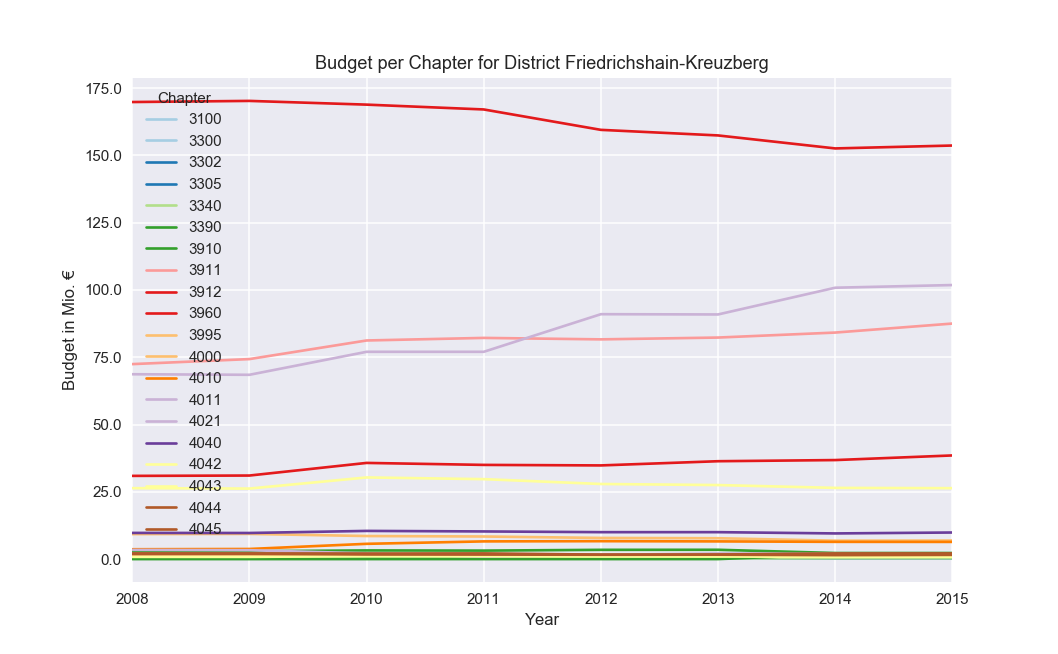

In [14]:
district = 2  # Set district number betwwen 1 and 12 here

fig, ax = plt.subplots(num=1, figsize=(9.7, 6))
data.loc[district].plot(colormap='Paired', ax=ax)
ax.set_ylabel('Budget in Mio. €')
ax.set_yticklabels(ax.get_yticks() / 10**6);
ax.set_xticklabels(data.index.levels[1].values.astype(str));
ax.set_title('Budget per Chapter for District ' + district_name[district])
ax.legend(loc='best', title='Chapter');

## What are the Topmost Expense Categories

In [15]:
data.loc[district, minyear].sort_values(ascending=False)

Chapter
3960    169847000.0
3911     72454200.0
4021     68692000.0
3912     30922000.0
4042     26361500.0
4040      9728900.0
3995      9281400.0
4010      3656400.0
4011      3421900.0
3910      3002100.0
4044      2107500.0
4045      1906800.0
4000      1007900.0
4043       821500.0
3300       794700.0
3305       751300.0
3100       689100.0
3340       395300.0
3302       296000.0
3390            0.0
Name: (2, 2008), dtype: float64

## Set Categories to Keep Separately (the Rest Will Be Aggregated in Category 9999)
Add the number of the categories you want to keep to the _set_ below!

In [16]:
keep = set([3960, 3911, 4021, 3912, 4042])

sumup = chapters.difference(keep)
data[9999] = data.loc[:, sumup].sum(axis=1)
data.drop(sumup, axis=1, inplace=True)

chapters.intersection_update(keep)
chapter_dict = dict([(chapter, chapter_dict[chapter]) for chapter in chapters])
chapter_info = {chapter for chapter in chapter_info if chapter[0] in keep}

chapters.add(9999)
chapter_dict.update({9999: 'other'})
chapter_info.add((9999, 'other'))

## Plot Again to Check that You Are Happy with the Aggregation (If Not, Start All Over ;-)
Choose the district number in the first line of the cell below! Keep in mind that Berlin has no more than 12 districts total ...

<IPython.core.display.Javascript object>


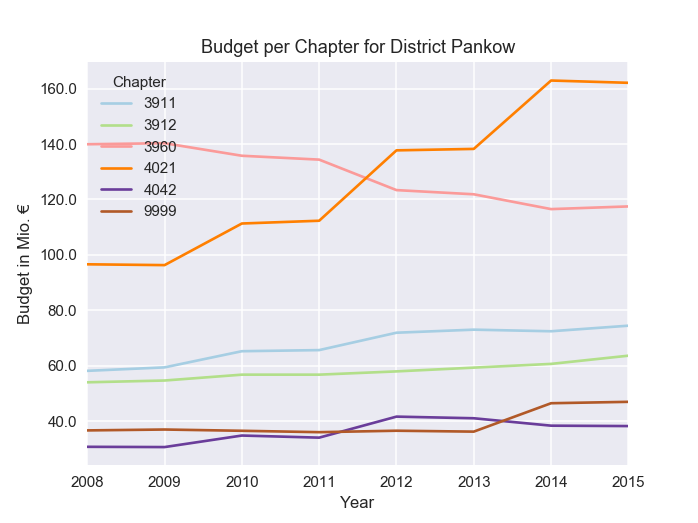

In [17]:
district = 3  # Set district number between 1 and 12 here

fig, ax = plt.subplots(num=2)
data.loc[district].plot(colormap='Paired', ax=ax)
ax.set_ylabel('Budget in Mio. €')
ax.set_yticklabels(ax.get_yticks() / 10**6);
ax.set_xticklabels(data.index.levels[1].values.astype(str));
ax.set_title('Budget per Chapter for District ' + district_name[district]);
ax.legend(loc='best', title='Chapter');

## Visualize Correlation Between Expense Categories per District
Choose the district number in the first line of the cell below! Keep in mind that Berlin has no more than 12 districts total ...

<IPython.core.display.Javascript object>


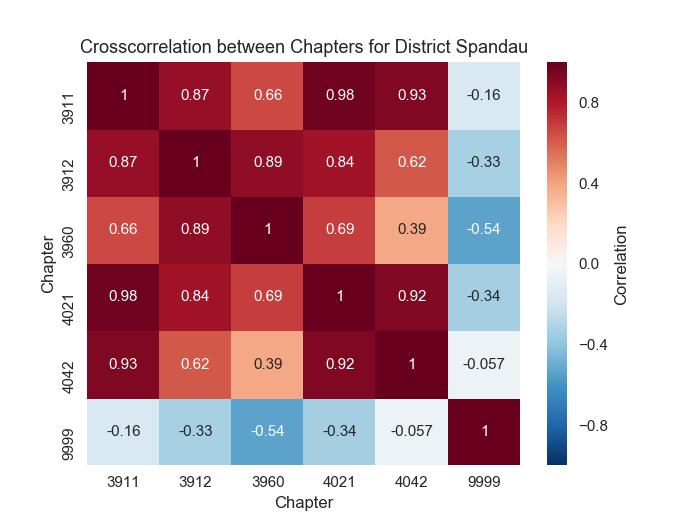

In [18]:
district = 5  # Set district number between 1 and 12 here

fig, ax = plt.subplots(num=3)
sbn.heatmap(data.loc[district].corr(), annot=True, cbar_kws={'label': 'Correlation'}, ax=ax)
ax.set_title('Crosscorrelation between Chapters for District ' + district_name[district]);

## View Total Expenses per Catergory of All Districts Together

<IPython.core.display.Javascript object>


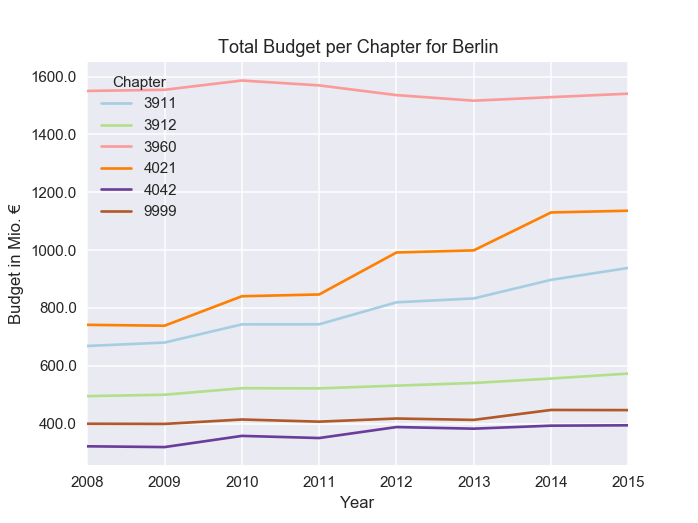

In [19]:
fig, ax = plt.subplots(num=4)
data.sum(level=1).plot(colormap='Paired', ax=ax)
ax.set_ylabel('Budget in Mio. €')
ax.set_yticklabels(ax.get_yticks() / 10**6);
ax.set_xticklabels(data.index.levels[1].values.astype(str));
ax.set_title('Total Budget per Chapter for Berlin');
ax.legend(loc='best', title='Chapter');

## View Sum of All Expense Categories per District

<IPython.core.display.Javascript object>


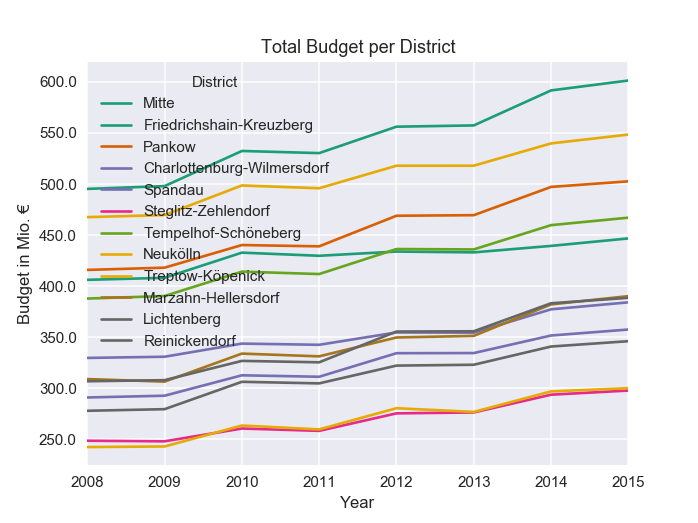

In [20]:
fig, ax = plt.subplots(num=5)
data.sum(axis=1).unstack('District').plot(colormap='Dark2', ax=ax)
ax.set_ylabel('Budget in Mio. €')
ax.set_yticklabels(ax.get_yticks() / 10**6);
ax.set_xticklabels(data.index.levels[1].values.astype(str));
ax.set_title('Total Budget per District');
labels = [district_name[int(district.get_text())] for district in ax.get_legend().get_texts()]
ax.legend(loc='best', title='District', labels=labels);

## Visualize Which Fraction of the Total Budget is Covered by the Considered Categories

<IPython.core.display.Javascript object>


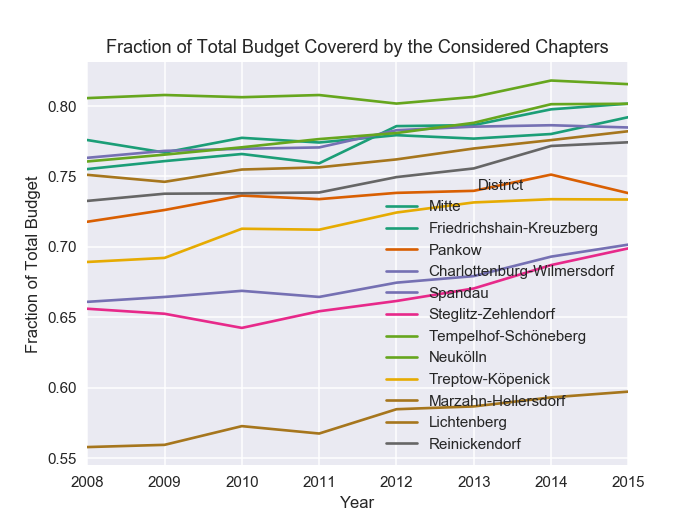

In [21]:
fig, axis = plt.subplots(num=6)
axis.set_prop_cycle('color',plt.cm.Dark2([i/12 for i in range(12)]))

for district in range(1,13):
    (data.sum(axis=1) / total.squeeze()).loc[district].plot(label=district_name[district], x=axis)

axis.set_ylabel('Fraction of Total Budget')
axis.set_xticklabels(data.index.levels[1].values.astype(str));
axis.set_title('Fraction of Total Budget Covererd by the Considered Chapters');
axis.legend(loc='best', title='District');

## Write Final Data to Disk

#### Set up descriptive parts of the export-file name

In [22]:
file_spec = '_' + str(minyear) + '-' + str(maxyear)

#### Now write first the more fine-grained version ...
The total expenses are added as a column labeled '10000'

In [23]:
data_name = 'budget' + file_spec + '.csv'
data = data.join(total)
data.to_csv(data_name)

#### ... then the consolidated version with just the main issues of social and youth spending
The total expenses are added as a column labeled '10000'

In [24]:
consolidated_name = 'consolidated' + file_spec + '.csv'
total.columns = ['Total']
consolidated = consolidated.join(total)
consolidated.to_csv(consolidated_name)

### Data should be read in again with ...

In [ ]:
my_name = pd.read_csv(data_name)
my_name.set_index(['District', 'Year'], inplace=True)

### ... and, likewise, consolidated data should be read in like so:

In [ ]:
my_name = pd.read_csv(consolidated_name)
my_name.set_index(['District', 'Year'], inplace=True)